---
title: "CS 546: Homework 2"
author: "Trent VanHawkins"
date: today
format: 
    pdf:
        geometry: "margin=0.75in"
        mathspec: true
        code-overflow: wrap
        cap-location: bottom
        tbl-cap-location: bottom
        header-includes: 
        - \usepackage{fancyhdr, amsthm, amssymb,amsfonts,amsthm, amsmath, bbm}
        - \usepackage{float, tabularx}
        - \floatplacement{table}{H}
        - \pagestyle{fancy}
        - \fancyhead[R]{Homework 2}
        - \fancyhead[L]{Trent VanHawkins}
        - \fancyfoot[C]{\thepage} # Center page number at bottom of each page
page-layout: full
execute: 
  eval: true
---

In this homework assignment you will be analyzing a gene regulatory network for the bacterial model species *E.&nbsp;coli*.

Install cairo and igraph; import cairo, igraph, pandas, matplotlib, numpy, random, and itertools

In [125]:
import cairo
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import pprint
import itertools

You will also need to download the file `ecolitfnet.txt` from the CSX46 S3 bucket, from the URL [https://csx46.s3-us-west-2.amazonaws.com/ecolitfnet.txt](https://csx46.s3-us-west-2.amazonaws.com/ecolitfnet.txt). In case you want to check that you have a complete and uncorrupted version of the file, here is it's MD5 checksum: 89d3688fca40e34cff23f4c2b703e427.

In [126]:
!curl https://csx46.s3-us-west-2.amazonaws.com/ecolitfnet.txt \
    --output ../DataRaw/ecolitfnet.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2381  100  2381    0     0  13121      0 --:--:-- --:--:-- --:--:-- 13154


For consistency of results, go ahead and set the random number seed to 1337

In [127]:
random.seed(1337)

Load in the *E.&nbsp;coli* operon-operon network (gene regulatory network) data in edge-list format; display the first six lines of data as a sanity check. Use `pandas.read_csv` and `pandas.DataFrame.head`.

In [128]:
edge_list_df = pd.read_csv("../DataRaw/ecolitfnet.txt", sep="\t", names=["source","target"])
edge_list_df.shape
edge_list_df.head(n=6)

,source,target
0,ADA,AIDB
1,ADIY,GADX
2,ALLR,ALLS
3,ARCA,BETI
4,ARCA,DPIA
5,ARCA,FNR


Make an igraph directed graph from the network; print a graph summary as a sanity check.  You will need to use `igraph.Graph.TupleList` and `summary`.

In [ ]:
eco_graph = ig.Graph.TupleList(edge_list_df.values.tolist(), 
                               directed=True)
eco_graph.summary()

'IGRAPH DN-- 133 261 -- \n+ attr: name (v)'

# Part I: Three-vertex motif analysis

## Question 1

_There are 13 different types of connected 3-vertex motifs (“isomorphism classes”) for a digraph. Which one of these motifs is most frequent in the E. coli regulatory network?_

Obtain the counts of all three-vertex motifs in the graph. You will need to use the `motifs_randesu` method in `igraph.Graph`.

In [130]:
motif_list = eco_graph.motifs_randesu(size=3)
motif_list

[nan, nan, 275, nan, 125, 39, 1676, 47, 25, 68, 0, 0, 2, 10, 1, 1]

## Answer to Question 1:
From looking at the position in the list of motif counts, the most frequently occuring three-vertex motif is motif "Class 6", which had a count of 1,676.

## Question 2, part A

_Which one of these motifs has a count of 47 in the regulatory network?_

In [131]:
motif_47c = int(np.where(np.array(motif_list) == 47)[0][0])

print(f"The motif with a count of 47 in the regulatory network is motif class {motif_47c}.")


The motif with a count of 47 in the regulatory network is motif class 7.


## Answer to Question 2, part A

From the results above, the motif with count 47 on the "real graph" is Class 7. Manually create an `igraph.Graph` directed graph object with three vertices, and then plot the graph. Make sure that the graph that you created looks like the three-vertex "Class 7" motif graph shown in the Canvas assignment for this homework.

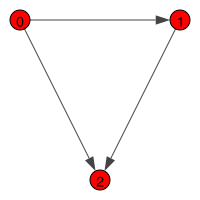

In [132]:
# Plot a network diagram of the motif
class7_el = [(0, 1), (0, 2), (1,2)]

class7_g = ig.Graph.TupleList(class7_el, directed=True)
ig.plot(class7_g, bbox=(0, 0, 200, 200), vertex_label = [0, 1, 2])

Now, call the `igraph.Graph.isoclass` method on the three-vertex igraph graph that you just created. It should return 7.

In [133]:
# print the isomorphism class
ig.Graph.isoclass(class7_g)

7

## Question 2, part B

_What are the mean and standard deviation of the MM counts for the 10,000 random networks?_

Get motif counts for 10,000 different randomizations of the network.  You will need to use a `for` loop, `igraph.Graph.copy`, `igraph.Graph.rewire`, and `append`.  You can specify n=1000 for the rewiring.  You can use `itertools.repeat` to perform 10,000 loops if you like.

In [ ]:
nsim = 10000
nrewire = 1000
counts = []

def rewire_and_count(graph, nrewire, size):
    tmp_graph = ig.Graph.copy(graph)
    ig.Graph.rewire(tmp_graph, n=nrewire)
    return tmp_graph.motifs_randesu(size=size)

counts = list(map(rewire_and_count, 
                  itertools.repeat(eco_graph, nsim), 
                  itertools.repeat(nrewire, nsim), 
                  itertools.repeat(3, nsim)))

For each motif type, compute the mean and standard deviation of the counts of appearances of the motif in each of the 10,000 randomly rewired graphs. You will need to use the `numpy.mean` and `numpy.std` functions.

In [135]:
#Convert list of lists to np array
counts_arr = np.array(counts)

#Take means and 
col_means = np.mean(counts_arr, axis=0)
col_std = np.std(counts_arr, axis=0)

#Print as a data frame
motif_df = pd.DataFrame({"Motif": range(0, len(motif_list)),
              "Count (Mean)": col_means,
              "Count (Std. Dev.)": col_std})

Print out the mean and the standard deviation of the numbers of feed-forward loops (FFLs) in random networks. Print the number of FFLs on the real network. The FFL should be at index position 7 (starting from zero!) of the vector returned from `motifs_randesu`.

In [136]:
print(motif_list[7])
motif_df.iloc[7, :]

47


Motif                 7.000000
Count (Mean)         57.207900
Count (Std. Dev.)     9.297789
Name: 7, dtype: float64

## Answer to Question 2, Part B

On average, there were 52.24 (sd = 9.24) feed-forward loops in the 10,000 simulated rewired networks. There were 47 in the original network. 

## Question 3

_What is the Z-score for enrichment of the MM count for the real network vs. the ensemble of random networks?  Does this Z-score correspond to a statistically significant positive enrichment?_

For each motif type, obtain the *Z* score for the number of appearances of the motif in the real network, vs. in the randomly rewired networks. Note, some of the motif counts are all zero, so we will set NumPy to ignore divide-by-zero errors before we do the vector element-wise division operation.

In [137]:
from scipy import stats
real_counts = np.array(eco_graph.motifs_randesu(3))

def get_zscore(network, surrogate, sigma): 
    return (network - surrogate) / sigma

zscores = list(map(get_zscore, real_counts, col_means, col_std))
p_values = [2 * (1 - stats.norm.cdf(abs(z))) for z in zscores]  # Assuming Z-scores follow a standard normal distribution

Print the _z_-score for the FFL

## Answer to Question 3

In [138]:
print(f"The z-score for motif class 7 is {zscores[7]:.2f} (p = {p_values[7]:.2f}).")

The z-score for motif class 7 is -1.10 (p = 0.27).


## Question 4.

_What is the ratio of the MM count for the real network to the average MM count for the random networks?_

Print out the ratio of the FFL count for the real network, to the average FFL count for the random networks

## Answer to Question 4

In [139]:
print(f"The ratio of the real count to the mean surrogate count for the FFL is {real_counts[7] / col_means[7]:.2f}.")

The ratio of the real count to the mean surrogate count for the FFL is 0.82.


## Question 5.

_How does ratio compare to the same ratio for the data in Table 1 in Shen-Orr et al., Nature Genetics, 2002?_

Adding up the first two rows of Table 1 in Shen-Orr et al., we get a count of 40 FFLs in the real network vs. an average of 6.9 in the randomized networks. Print the ratio:

## Answer to Question 5

In [140]:
real_ratio = 40/6.9
print(f"The ratio of the real count to the mean surrogate count for the FFL in Shen-Orr et al is {real_ratio:.2f}.")

The ratio of the real count to the mean surrogate count for the FFL in Shen-Orr et al is 5.80.


## Question 6

_Given the modest ratio of the MM frequency in the real network vs. randomly shuffled network, should we entertain the possibility that the high frequency of MMs in the real network could be a consequence of the degree distribution rather than evolution specifically “favoring” FFLs as a building block for gene regulatory networks?_

## Answer to Question 6:

Our findings are extremely different from those of Shen-Orr et al. We found 47 feed-forward loops in the real network ($Q_{\text{Network}} = 47$) and 57 in the simulated networks $Q_{\text{Surrogate}} \approx 57$ ($\text{sd} = 9.3$). At $\alpha = 0.05$, we fail to reject the null hypothesis ($z = -1.1, p = 0.27$) that the number of feed-forward loops observed in our network is significantly different from what would be expected by random chance. This is a dramatic difference from Shen-Orr et. al. 

# Part II. Four-vertex motif analysis

## Question 1

_What is the count of this four-vertex motif in the E. coli gene regulatory network?_

Figure out the isomorphism class of the network shown in the assignment in Canvas.  You'll want to build an edge-list tuple-list and then an igraph `Graph` object using `Graph.TupleList` (make sure to specify a directed graph!), and then use the `igraph.Graph.isoclass` method.

In [141]:
part2_el = [(1, 3), (1, 4), (2, 3), (2, 4)]
part2_g = ig.Graph.TupleList(part2_el, directed=True)
ig.plot(part2_g, bbox=(0, 0, 200, 200), vertex_label = [1, 2, 3, 4])
ig.Graph.isoclass(part2_g)

19

Compute the number of appearances of this four-vertex motif in the real network, using `motifs` with `size=4`.

## Answer to Question 1

In [142]:
p2_count = eco_graph.motifs_randesu(size=4)
print(f"The count of motif class 19 in the E. coli regulatory network is {p2_count[19]}.")

The count of motif class 19 in the E. coli regulatory network is 297.


## Question 2

_What are the average (and standard deviation) of the counts of this motif in 10,000 randomly shuffled networks?_

(you can compute this similarly to what you did for the three- vertex motifs above).

Get the mean and standard deviation for the count of four-vertex motifs in 10,000 randomly rewired graphs.  You will need to use a `for` loop, `igraph.Graph.copy`, `igraph.Graph.rewire`, and `list.append`.  You can specify *n*=1,000 for the rewiring.

In [ ]:
counts_p2 = list(map(rewire_and_count, 
                     itertools.repeat(eco_graph, nsim), 
                     itertools.repeat(nrewire, nsim), 
                     itertools.repeat(4, nsim)))

Use `numpy.mean` and `numpy.stdev` to compute the mean and standard deviation of the counts of this motif on the randomly rewired graphs.

## Answer to Question 2

In [146]:
#Convert list of lists to np array
counts_p2_arr = np.array(counts_p2)

#Take means and 
col_means_p2 = np.mean(counts_p2_arr, axis=0)
col_std_p2 = np.std(counts_p2_arr, axis=0)

#Print as a data frame
motif_df = pd.DataFrame({"Motif": range(0, len(p2_count)),
              "Count (Mean)": col_means_p2,
              "Count (Std. Dev.)": col_std_p2})
print(motif_df.iloc[19, :])

Motif                 19.00000
Count (Mean)         176.74110
Count (Std. Dev.)     38.32952
Name: 19, dtype: float64


## Question 3

_What is the *Z*-score for enrichment of this four-vertex motif?  Is it significant?_

In [150]:
zscores_p2 = list(map(get_zscore, p2_count, col_means_p2, col_std_p2))
p_values_p2 = [2 * (1 - stats.norm.cdf(abs(z))) for z in zscores_p2] 
print(f"The z-score for motif class 19 is {zscores_p2[19]:.2f} (p = {p_values_p2[19]:.3f}).")

The z-score for motif class 19 is 3.14 (p = 0.002).


/var/folders/lt/4hpy5xm52tl3dl30dfm7545w0000gn/T/ipykernel_61835/3269090675.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return (network - surrogate) / sigma


## Question 4

_What is the ratio of the count in the real network to the average count for the random networks?  How does this ratio compare to the ratio that you obtain from Table 1 from Shen-Orr et al.? Are they consistent? Does this suggest that Shen-Orr’s actual network randomization procedure is possibly not consistent with their description in the Methods section of their paper, i.e., that it may have had some kind of error? (if you are interested in this topic, see the paper by Konagurthu and Lesk, BMC Systems Biology, 2008, 2:73 [Konagurthu_BMCSystBiol_2008.pdf](https://drive.google.com/file/d/1yO-ZXc0SZpwsLFyr_14n3AsP1T-PjAYu/view?usp=share_link)_

## Answer to Question 4

In [ ]:
#Compute my ratio
my_ratio = p2_count[19] / col_means_p2[19]
print(f"The ratio of the real count to the mean surrogate count for motif class 19 from our analysis is {my_ratio:.2f}.")

#Compute Shen-Orr ratio
schen_ratio = 203/57
print(f"The ratio of the real count to the mean surrogate count for motif class 19 from Shen-Orr et al is {schen_ratio:.2f}.")

The ratio of the real count to the mean surrogate count for motif class 19 from our analysis is 1.68.
The ratio of the real count to the mean surrogate count for motif class 19 from Shen-Orr et al is 3.56.


Again, we see that our result is quite different from that of Shen-Orr et al. This does, perhaps, suggest some type of error in their randomization but we can notice that both lead to a statistically significant difference between the observed and mean-simulated count of DORs. The magnitude of their finding is just much larger (about 3x). 

